<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-библиотек" data-toc-modified-id="Загрузка-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#XGBClassifier" data-toc-modified-id="XGBClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>XGBClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Загрузка библиотек

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# !pip install cuml

In [3]:
import datetime, re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
import matplotlib.pyplot as plt
from tqdm import notebook
from datetime import datetime
from pprint import pprint
from wordcloud import WordCloud 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, make_scorer, f1_score

# from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, BertModel, BertConfig, RobertaConfig, RobertaModel, RobertaTokenizer, AutoModel, AutoTokenizer

import pandarallel  # Может не работать на Windows
pandarallel.pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


### Загрузка данных

In [4]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/toxic_comments.csv")

In [5]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,159292.0,NaN,NaN,NaN,79725.697242,46028.837471,0.0,39872.75,79721.5,119573.25,159450.0
text,159292,159292,Explanation\nWhy the edits made under my usern...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toxic,159292.0,NaN,NaN,NaN,0.101612,0.302139,0.0,0.0,0.0,0.0,1.0


Удалим столбец "Unnamed: 0" - похоже, что почти всегда он дублирует индексы

In [8]:
data = data.drop(["Unnamed: 0"], axis=1)

In [9]:
# data2 = data.sample(2000).reset_index()

In [10]:
X = data["text"]

In [11]:
y = data["toxic"]

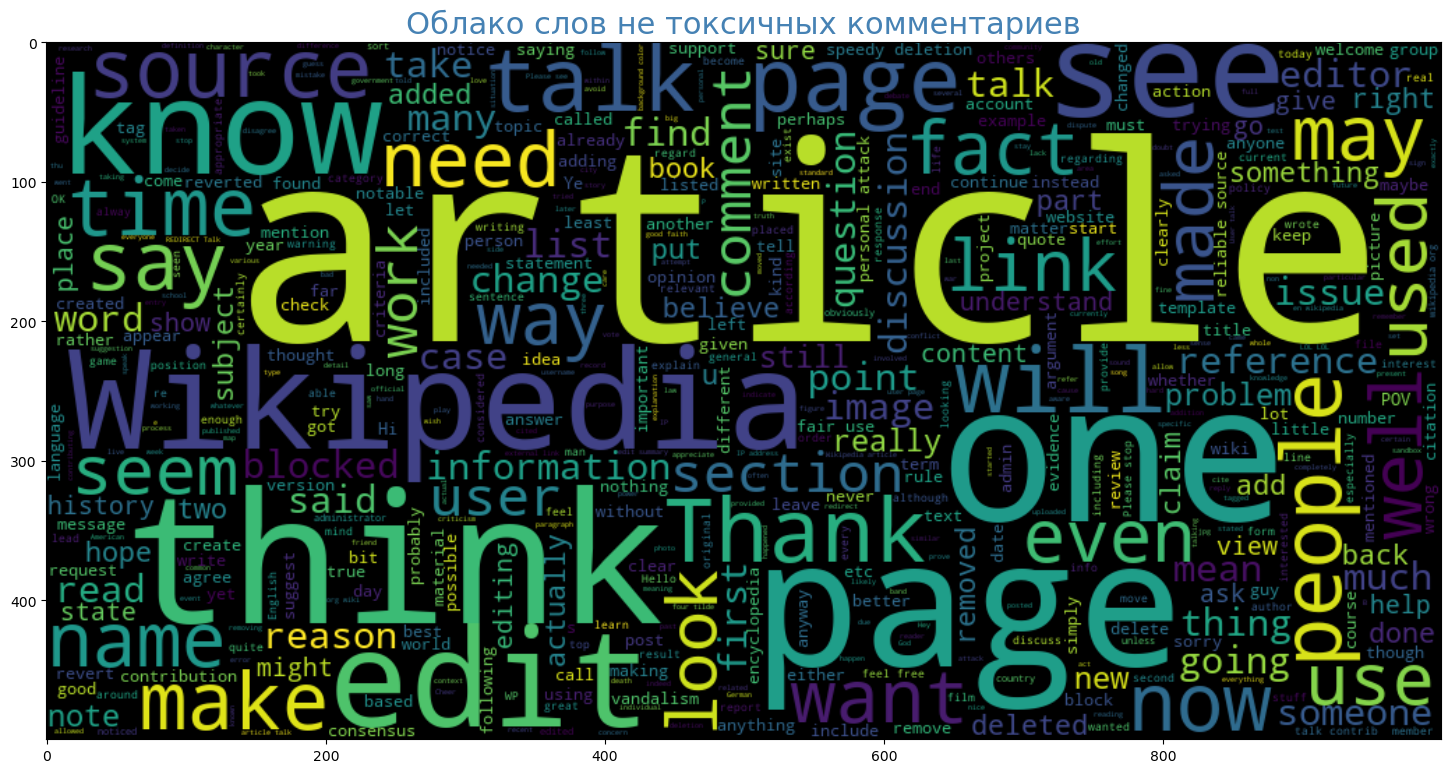

In [12]:
plt.figure(figsize=(18,18))
text = ' '.join(data[data["toxic"]==0]["text"].values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.title('Облако слов не токсичных комментариев', fontsize = 22, color = 'SteelBlue');
plt.show;

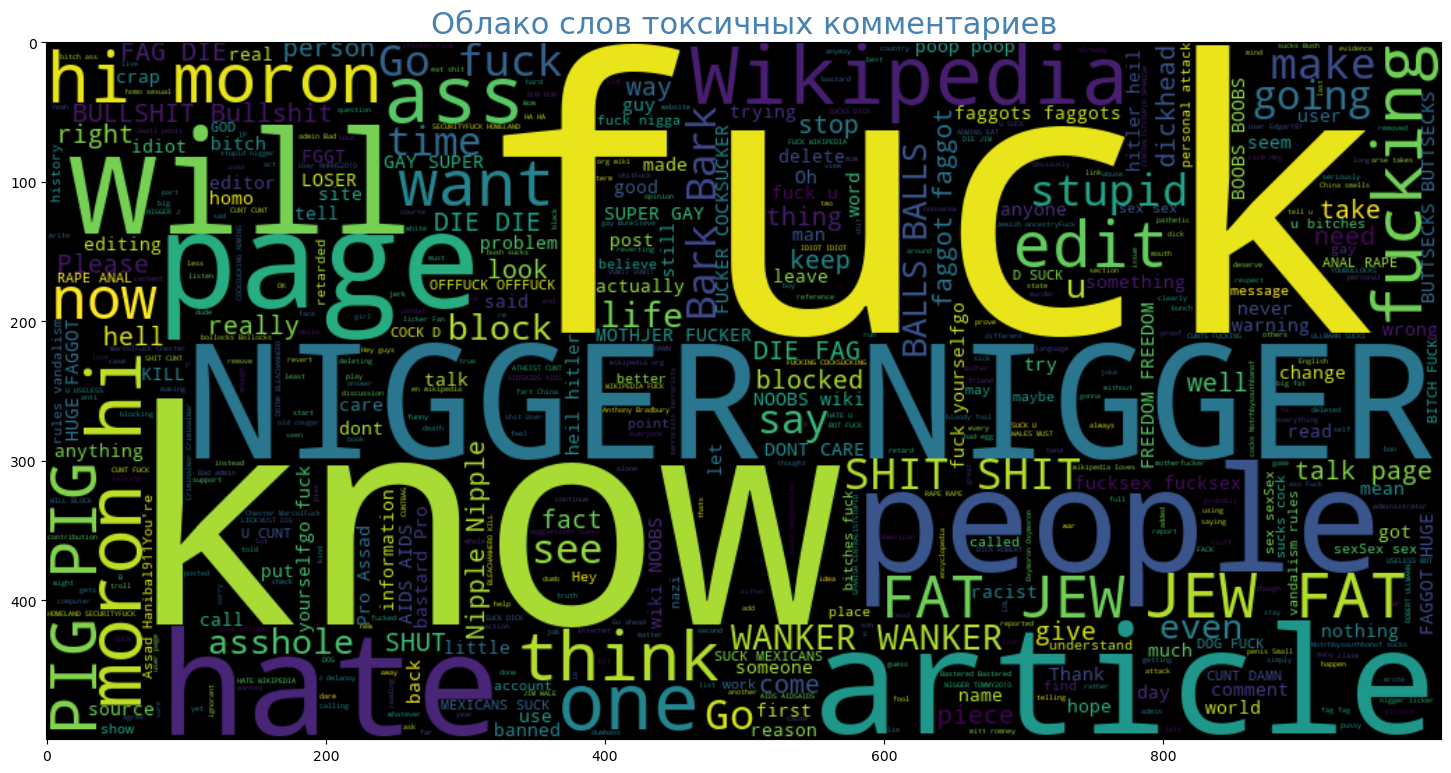

In [13]:
plt.figure(figsize=(18,18))
text = ' '.join(data[data["toxic"]==1]["text"].values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.title('Облако слов токсичных комментариев', fontsize = 22, color = 'SteelBlue');
plt.show;

<img src="https://cs5.pikabu.ru/images/big_size_comm/2015-08_4/1440077395118086059.png"  width="200">

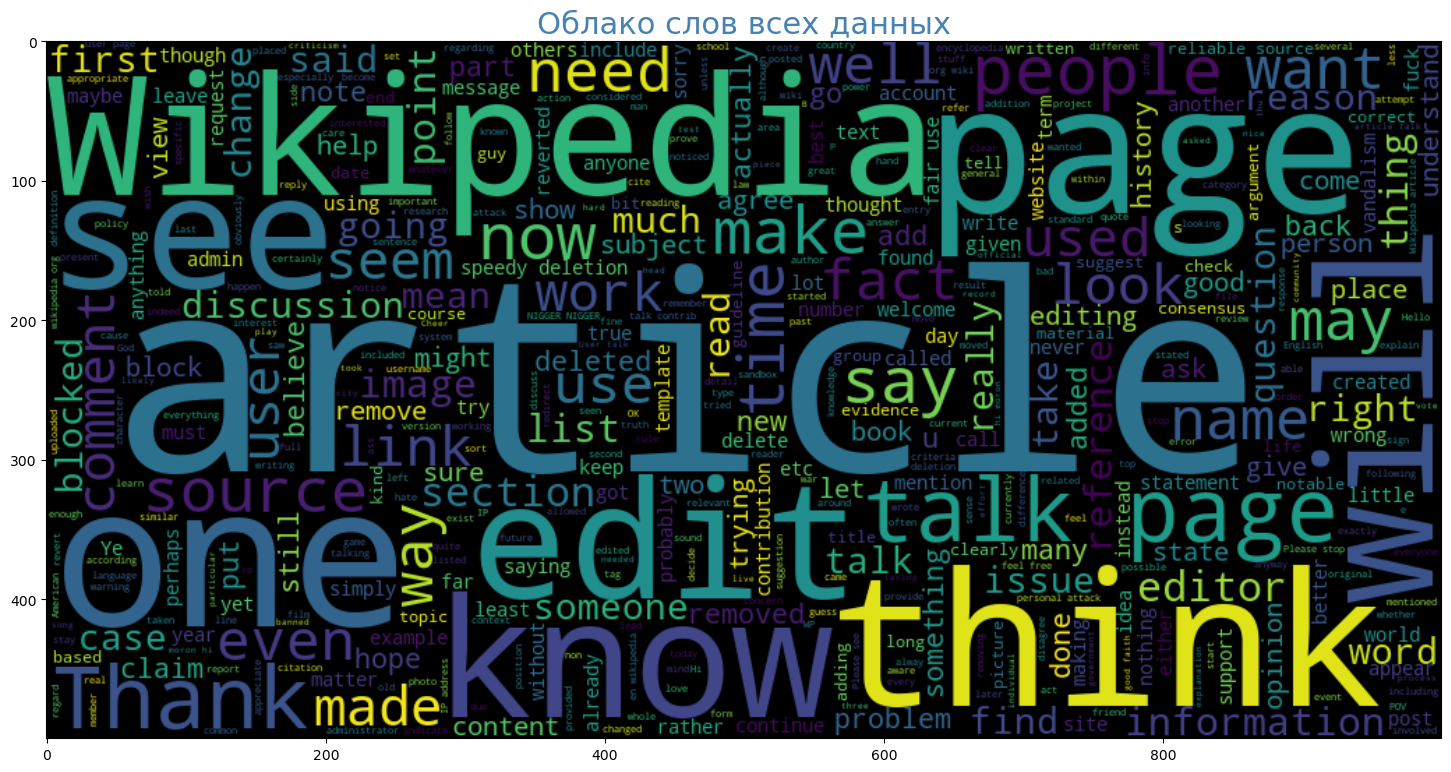

In [14]:
plt.figure(figsize=(18,18))
text = ' '.join(X.values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.title('Облако слов всех данных', fontsize = 22, color = 'SteelBlue');
plt.show;

### Подготовка данных

С помощью регулярных выражений уберем:  
- перед запятой ставим пробел
- символ переноса строки
- перед точкой с пробелом ставим пробел

In [15]:
X = X.str.lower()
pattern = re.compile(r"https?://[^,\s]+,?")
X = X.apply(lambda line: pattern.sub('', line))
pattern = re.compile(r"\b(?:\d{1,3}\.){3}\d{1,3}\b")
X = X.apply(lambda line: pattern.sub('', line))
pattern = re.compile(r'[^\x00-\x7F]+')
X = X.apply(lambda line: pattern.sub('', line))
pattern = re.compile('\\s+')
X = X.apply(lambda line: pattern.sub(' ', line))

Предобработка текстов

In [16]:
mod = 'unitary/toxic-bert'
tokenizer = AutoTokenizer.from_pretrained(mod)
model = AutoModel.from_pretrained(mod)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# Устанавливаем ГПУ для расчета, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [18]:
device

device(type='cuda')

In [19]:
# Конвертируем исходные данные в токенизированные
tokenized = X.apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

In [20]:
# Применяем padding к векторам
max_len = max(len(i) for i in tokenized.values)
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

In [21]:
# создадим маску для важных токенов
attention_mask = np.where(padded != 0, 1, 0)

In [22]:
# Initialize embeddings list
embeddings = []

In [23]:
# Размер батча
batch_size = 100

In [24]:
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

    # Generate embeddings for the batch
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)[0][:, 0, :].cpu().numpy()

    embeddings.append(batch_embeddings)

# Объединяем всё в один эмбендинг
embeddings = np.concatenate(embeddings, axis=0)

  0%|          | 0/1592 [00:00<?, ?it/s]

In [25]:
# Приведем размер целевых признаков под размер эмбендинга
y = y[0:len(embeddings)]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, 
    test_size=0.25, 
    random_state=12345
)

## Обучение

Возьмем две модели LogisticRegression и RandomForestClassifier

In [61]:
models_scores = {
        'model': [],
        'time_train': [],
        'time_f1': [],
        'F1_train': []
    }

In [28]:
# Определение метрики F1 как scoring
scoring = make_scorer(f1_score)

### LogisticRegression

In [55]:
start_lr_tr = datetime.now()
lr_model = LogisticRegression(random_state=12345)
lr_model.fit(X_train, y_train)
time_lr_tr = datetime.now() - start_lr_tr

start_lr_f1 = datetime.now()
lr_cvs = cross_val_score(lr_model, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
time_lr_f1 = datetime.now() - start_lr_f1

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [59]:
lr_cvs_f1 = round(lr_cvs.mean(), 2)

In [62]:
models_scores['model'].append('LinearRegression')
models_scores['time_train'].append(time_lr_tr)
models_scores['time_f1'].append(time_lr_f1)
models_scores['F1_train'].append(lr_cvs_f1)

print('F1 метрика:', lr_cvs_f1)
print('Время обучения:', time_lr_tr)
print('Время оценки качества:', time_lr_f1)

F1 метрика: 0.94
Время обучения: 0:00:02.990845
Время оценки качества: 0:00:13.192987


### RandomForestClassifier

In [63]:
start_rfr_tr = datetime.now()
rfc_model = RandomForestClassifier(random_state=12345, verbose=2)
rfc_model.fit(X_train, y_train)
time_rfr_tr = datetime.now() - start_rfr_tr

start_rfr_f1 = datetime.now()
rfc_cvs = cross_val_score(rfc_model, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
time_rfr_f1 = datetime.now() - start_rfr_f1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 16.1min finished


In [64]:
rfc_cvs_f1 = round(rfc_cvs.mean(), 2)

In [65]:
models_scores['model'].append('RandomForestClassifier')
models_scores['time_train'].append(time_rfr_tr)
models_scores['time_f1'].append(time_rfr_f1)
models_scores['F1_train'].append(rfc_cvs_f1)

print('F1 метрика:', rfc_cvs_f1)
print('Время обучения:', time_rfr_tr)
print('Время поиска параметров:', time_rfr_f1)

F1 метрика: 0.94
Время обучения: 0:16:07.571184
Время поиска параметров: 0:13:16.847950


### XGBClassifier

In [68]:
start_xgb_tr = datetime.now()
xgb_model = XGBClassifier(
    random_state=12345, tree_method="gpu_hist", colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50
)
xgb_model.fit(X_train, y_train)
time_xgb_tr = datetime.now() - start_xgb_tr

start_xgb_f1 = datetime.now()
xgb_cvs = cross_val_score(xgb_model, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
time_xgb_f1 = datetime.now() - start_xgb_f1

In [69]:
xgb_cvs_f1 = round(xgb_cvs.mean(), 2)

In [70]:
models_scores['model'].append('XGBRegressor')
models_scores['time_train'].append(time_xgb_tr)
models_scores['time_f1'].append(time_xgb_f1)
models_scores['F1_train'].append(xgb_cvs_f1)

print('F1 метрика:', xgb_cvs_f1)
print('Время обучения:', time_xgb_tr)
print('Время поиска параметров:', time_xgb_f1)

F1 метрика: 0.94
Время обучения: 0:00:02.581002
Время поиска параметров: 0:00:17.713490


In [74]:
analise_df = pd.DataFrame(
    models_scores
                         ).set_index('model')

In [75]:
analise_df

,time_train,time_f1,F1_train
model,,,
LinearRegression,0 days 00:00:02.990845,0 days 00:00:13.192987,0.94
RandomForestClassifier,0 days 00:16:07.571184,0 days 00:13:16.847950,0.94
XGBRegressor,0 days 00:00:02.581002,0 days 00:00:17.713490,0.94


In [77]:
analise_df['train_coef'] = \
(
    analise_df['time_train']/max(analise_df['time_train']) + 
    analise_df['time_f1']/max(analise_df['time_f1']) +  
    analise_df['F1_train']/max(analise_df['F1_train'])
) / 3

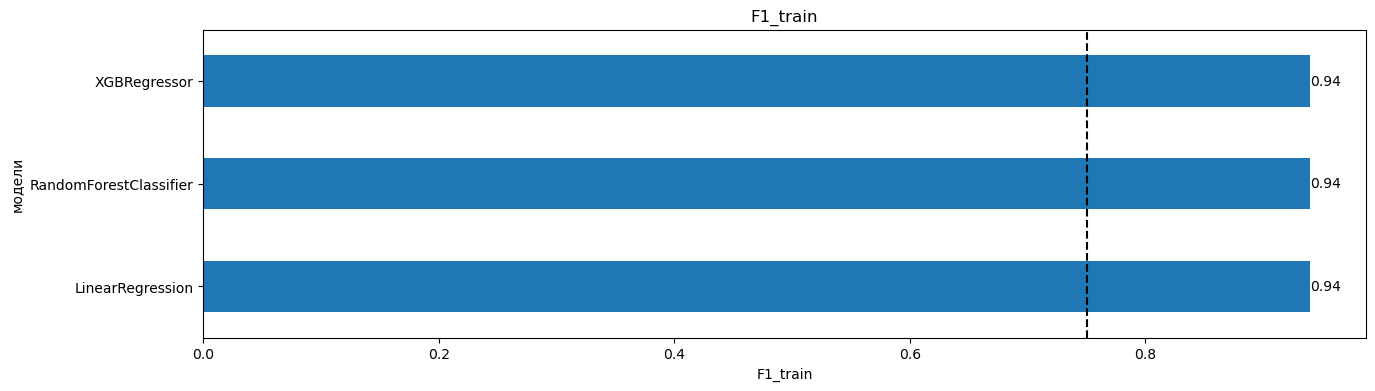

In [78]:
ax = analise_df['F1_train'].plot.barh(figsize=(15,4), legend=False, title='F1_train')
ax.axvline(x=0.75, color='black', linestyle='--')
ax.bar_label(ax.containers[0], color='black')
for bar in ax.containers[0]:
    if bar.get_width() <= 0.75:
        bar.set_color('#F57C00')
ax.set_xlabel("F1_train")
ax.set_ylabel("модели");

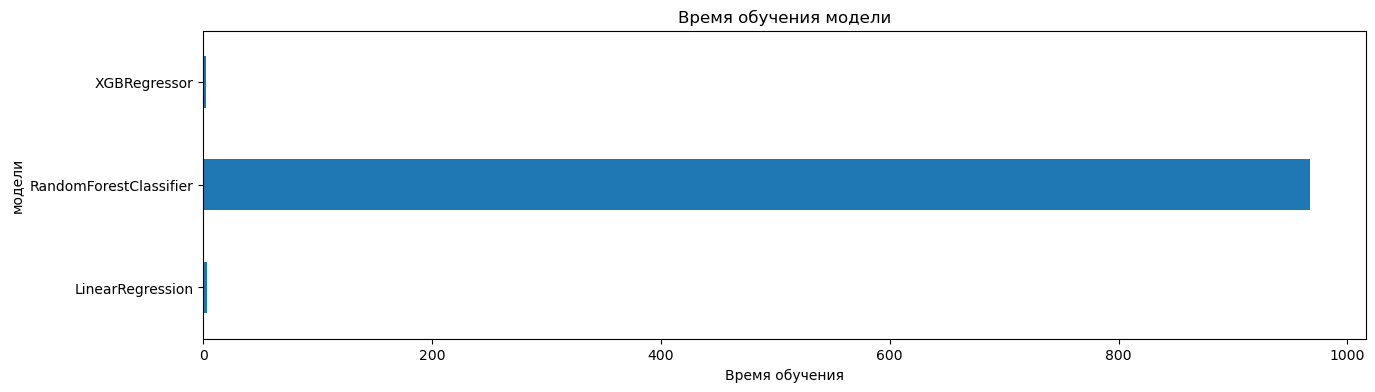

In [79]:
analise_df['time_train'] = analise_df['time_train'].dt.total_seconds()
ax = analise_df['time_train'].plot.barh(figsize=(15,4), legend=False, title='Время обучения модели')
ax.set_xlabel("Время обучения")
ax.set_ylabel("модели");

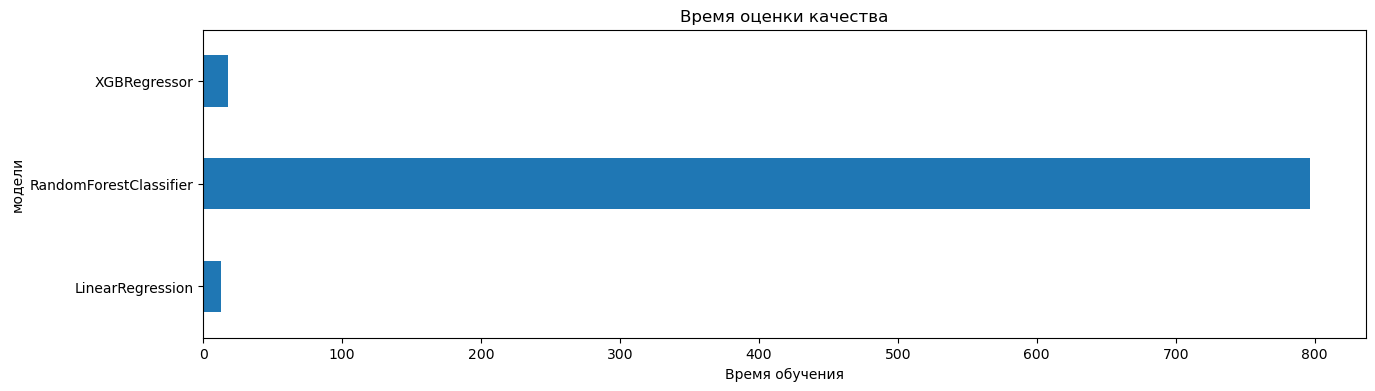

In [80]:
analise_df['time_f1'] = analise_df['time_f1'].dt.total_seconds()
ax = analise_df['time_f1'].plot.barh(figsize=(15,4), legend=False, title='Время оценки качества')
ax.set_xlabel("Время обучения")
ax.set_ylabel("модели");

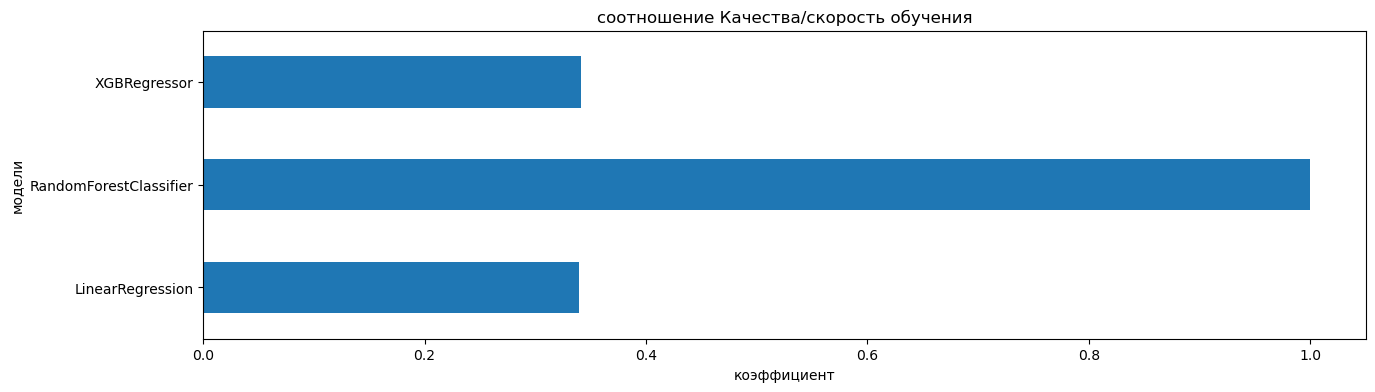

In [81]:
ax = analise_df['train_coef'].plot.barh(figsize=(15,4), legend=False, title='соотношение Качества/скорость обучения')
ax.set_xlabel("коэффициент")
ax.set_ylabel("модели");

У трёх выбранных моделей значение F1 оказалось примерно на одном уровне. Выберем LogisticRegression в качестве нашей модели. Проверим качество модели на тестовой выборке 

In [82]:
pred = lr_model.predict(X_test)

In [83]:
lr_f1_test = round(f1_score(y_test, pred), 2)

In [84]:
print(f"Logistic Regression F1 Score: {lr_f1_test}")

Logistic Regression F1 Score: 0.95


**Вывод**

Все выбранные модели прошли критерий качества F1 > 0.75 

После обучения и кросс-валидации выбрали лучшей моделью - LinearRegression. Проверили качество модели на тестовой выборке и получили значение 0.95 

## Выводы

**Входные данные**
- Из загруженных данных был удалён параметр "Unnamed: 0"
- Текстовые данные были токенизированы и конвертированы в вектора
- Целевой признак - "toxic"


**Модели**  
- Были взяты 3 модели: LogisticRegression, RandomForestClassifier, XGBClassifier  
- По критерию качества все модели показали примерно равный результат  
- По скорости обучения быстрее всех ( в районе 3-х сек) обучается LogisticRegression


**Лучшая модель**
Критерий качества модели **LogisticRegression**